Focusing packets
---
We now want to loop a series of focusing packets, adjusting two parameters
* The linear prediction of the maximum slope at focusing
* The bandwidth


To get some insight into this, we'll start by looking at this for one case, then loop through a 10x10 lattice in parameter space, and eventually do this for many runs. 

Goals
----
* Establish how we will run/save the data. This includes how we'll make cell structures
* Establish low resolution results regarding breaking criteria / breaking threshold. 

Things to be wary of
-----
* The "relative" resolution will be dependent on the bandwidth chosen, so that we need to think about how to choose the physical size of the domain. I think we likely want to say it should be X * the packet width. How do other people do this? 

Data flow
-----
For each run, we'll create a mat file (we should put the BW/S in the filename), which has a structure including the variables, (x,y,phi,t), as well as S, Delta, wl, x_b, N, g, k, w, M, x_f, y_f, f_f. 

dold.f:291:21:

       common /profil/ x(-6:N7),y(-6:N7),f(-6:N7),
                     1
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
STOP data is no longer intelligible

ii =

     1


ans =

    0.6500



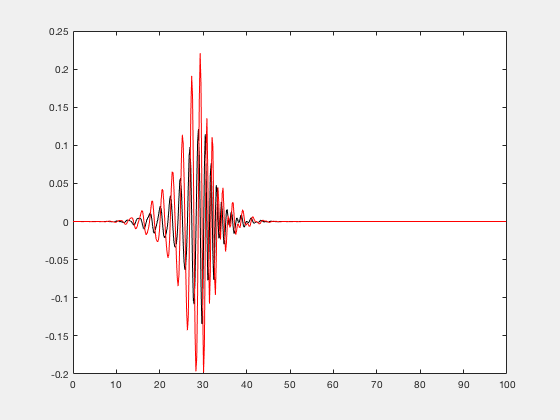

In [85]:
imatlab_export_fig('print-png')
cd /Users/airsealab/Documents/GitHub/particlekinematics/
N = 512;
ML = 100;
xo = -30;
x = xo:ML/N:xo+(ML)*(1-1/N);
wl = ML;
g = 9.81; 
% g=1;
k = (2*pi)^2/g; 
% k=2*pi;
w = sqrt(g*k); cg=g/2/w; 
tstart = cputime;

for ii = 1
D = 0.75;
xb = 15 / D;
tb = xb / cg;
S = 0.8 + (ii-1)*0.05;
M = 32;
kn = zeros(M,1);
wn = zeros(M,1);
an = zeros(M,1);
for i = 1 : M
    kn(i) = k*(1+D*(i-M/2)/M);
    wn(i) = sqrt(g*kn(i));
    an(i) = S/kn(i)/M;
end

eta1 = zeros(length(x),1);
for i = 1 : M
    eta1(:,1) = eta1(:,1) + an(i)*cos(kn(i)*(x'-xb)+wn(i)*tb);
end
clf
plot(x,eta1)
filt1=1/2*(tanh(0.25*(x--15))-tanh(0.25*(x-10)));
eta2=eta1.*filt1';
hold on
plot(x,eta2)
%
I=sqrt(-1);
Fs=1/(abs(x(2)-x(1)));

[out,freq]=positiveFFT(eta2',Fs);
eta=zeros(1,length(x)); 
    for j=1:length(x)
        eta(1,j) = sum(real(2*out(2:end).*exp(I*(2*pi*freq(2:end)*(x(j)+30)))));
    end
eps2=sum((abs(2*out(2:end)).*2.*pi.*freq(2:end)));
phi=zeros(1,length(x)); 
    for j=1:length(x)
        phi(1,j) = sum(imag(2*sqrt(g)*out(2:end)./sqrt(2*pi*(freq(2:end))).*...
           exp(I*((2*pi*freq(2:end))*(x(j)+30)-sqrt(g*2*pi*freq(2:end))*(0-0*tb)))));
    end
% BW=powerbw(eta,2*pi*Fs,[],10)/k 
BW=D;
%
clf
x_f=(x)'-xo;
% x_f2=(x)'-xo+30;
y_f=eta;
f_f=phi;
plot(x_f,y_f,'k')
hold on
plot(x_f,f_f,'r')
%
% delete k.txt
save xc.txt x_f -ascii
save yc.txt y_f -ascii
save fc.txt f_f -ascii
save S.txt eps2 -ascii
save S0.txt S -ascii
save bw.txt BW -ascii
save bw0.txt BW -ascii
save C.txt BW -ascii 
save wl.txt wl -ascii 
% save k.txt k -as
unix('./run2.sh'); 
%
formatSpec='%f'; 
fileID = fopen(['x.txt'], 'r');
xout = fscanf(fileID,formatSpec);
fclose(fileID); 
fileID = fopen(['y.txt'], 'r');
yout = fscanf( fileID, formatSpec);
fclose( fileID );
fileID = fopen(['phi.txt'], 'r');
pout = fscanf(fileID,formatSpec);
fclose(fileID);
fileID=fopen(['t.txt'], 'r');
to = fscanf(fileID,formatSpec);
fclose(fileID);
t=to(1:N:end);
nout_0=length(t);
nout=round(nout_0)-1;
data_o =zeros(N,nout_0);
x_o=zeros(N,nout_0);
y_o=zeros(N,nout_0);
p_o=zeros(N,nout_0);
for i=1:N
for j=1:nout_0
x_o(i,j)=xout(i+N*(j-1),1);
y_o(i,j)=yout(i+N*(j-1),1);
p_o(i,j)=pout(i+N*(j-1),1);
end
end
tf=islocalmin(x_o(:,end));
xi=0:2*pi/N:2*pi*(1-1/N);
dxi=abs(xi(2)-xi(1));
% need to create the structure 
% ii =1;
data.x = x_o;
data.y = y_o;
data.p = p_o;
data.t = t; 
data.N = N;
data.S = S;
data.BW = D;
data.xb = xb;
data.tb = tb;
data.k = k;
data.omega = w;
data.wl = wl;
data.x_0 = x_f;
data.y_0 = y_f;
data.f_0 = f_f;
data.broken = max(tf);
foc{ii,1} = data; 
save('foc.mat', 'foc')
ii
cputime-tstart
end

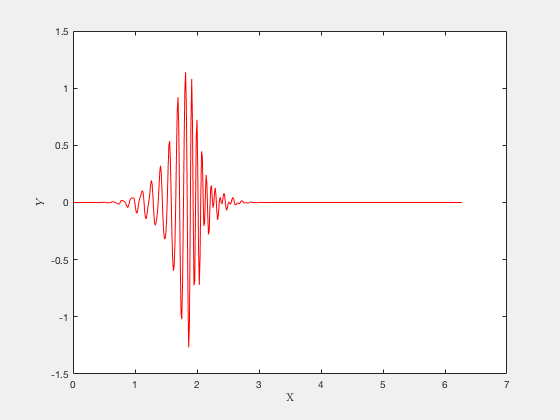

In [44]:
clf
set(gca,'fontsize',28)
for i=1:35:length(t)
plot(x_o(:,i),150*y_o(:,i)+1/2*t(i),'r')
% pause(0.1)
hold on
% xlim([0 2*pi])
% ylim([-1e-2 1e-2]) 
end
% set(gca,'fontsize',28)
xlabel('X','interpreter','latex')
ylabel('$Y$','interpreter','latex')

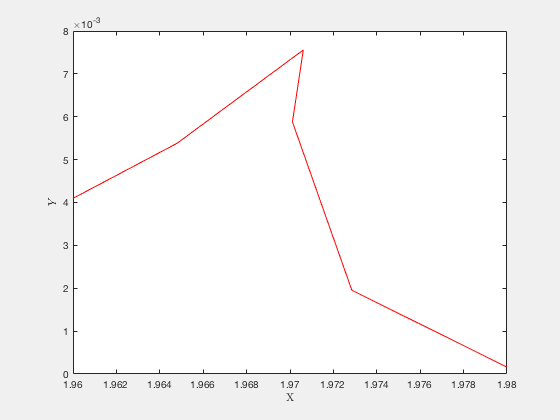

In [79]:
clf
set(gca,'fontsize',28)
for i=1:35:length(t)
plot(x_o(:,end),y_o(:,end),'r')
% pause(0.1)
hold on
xlim([1.96 1.98])
% ylim([-1e-2 1e-2]) 
end
% set(gca,'fontsize',28)
xlabel('X','interpreter','latex')
ylabel('$Y$','interpreter','latex')

Goals
----
How can we tell a wave has broken?
Check this against data.
Plot bandwidth (D) and S. Color each point black or red depending on if the wave broke.
Then do the same thing with double the resolution (1024 instead of 512) and compare them.

In [83]:
tf=islocalmin(x_o(:,end));

In [86]:
max(tf)


ans =

  logical

   1

